In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Expanding measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x220d28e2280>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
# Expanding station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x220d28ea130>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'id': 1,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

In [12]:
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

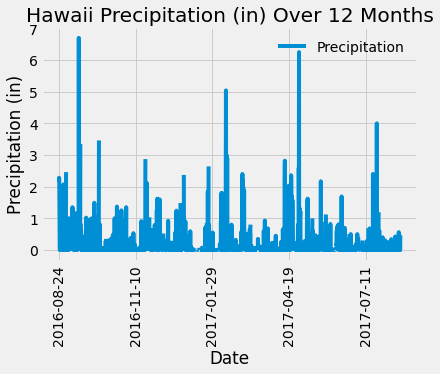

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()  # (2017-08-23)

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)  # (2016-8-23)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame(precipitation_data).set_index("date")

# Sort the dataframe by date
precipitation_data = precipitation_data.sort_values(by = "date")
precipitation_data.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data.plot()
plt.title("Hawaii Precipitation (in) Over 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.xticks(rotation=90)
plt.legend(["Precipitation"], loc = "upper right", frameon = False)
plt.savefig("Images/precipitation_12_months.png", bbox_inches='tight')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.count(Station.station)).scalar()
print(f'{stations_count} stations are available in this dataset.')

9 stations are available in this dataset.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_active = session.query(Measurement.station, func.count(Measurement.station))\
                            .group_by(Measurement.station)\
                            .order_by(func.count(Measurement.station).desc()).all()
stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
records = session.query(*sel).filter(Measurement.station == "USC00519281").all()
print(records)
print("")
print("The most active station is USC00519281")
print("The lowest temperature is 54.0")
print("The highest temperature is 85.0")
print("The average temperature is 71.66378066378067")

[(54.0, 85.0, 71.66378066378067)]

The most active station is USC00519281
The lowest temperature is 54.0
The highest temperature is 85.0
The average temperature is 71.66378066378067


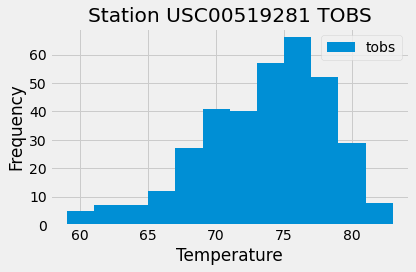

In [18]:
# Choose the station with  the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temperature_station = session.query(Measurement.date, Measurement.tobs)\
                                    .filter(Measurement.station == "USC00519281")\
                                    .filter(Measurement.date > year_ago).all()

station_df = pd.DataFrame(year_temperature_station)

station_df["tobs"].plot(kind = "hist", bins = 12)
plt.title("Station USC00519281 TOBS")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(["tobs"])
plt.tight_layout()
plt.savefig("Images/station_tobs.png")
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temperatures = calc_temps('2015-02-03', '2015-02-13')
temperatures

[(58.0, 69.81012658227849, 79.0)]

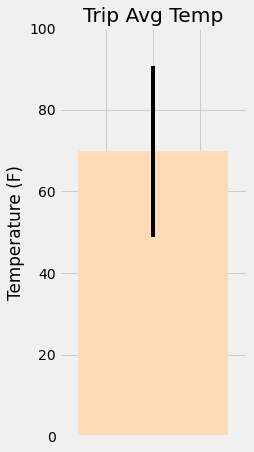

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

xvalues = [0]
yvalues = temperatures[0][1]
yerr = temperatures[0][2] - temperatures[0][0]
plt.figure(figsize=(3,7))
plt.bar(xvalues, yvalues, yerr=yerr, color='peachpuff')
plt.ylim(0,100)
plt.xlim(-0.5, 0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.savefig("Images/trip_avg_temp.png", bbox_inches='tight')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2015-02-03'
end_date = '2015-02-13'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= start_date)\
    .filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
results

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.53),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.87),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.30000000000000004),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  0.29000000000000004),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.26),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.2),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.16),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.08)]

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2015, 2, 3)
end_date = dt.date(2015, 2, 13)

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
date_list = [date.strftime("%m-%d") for date in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date)[0] for date in date_list]
normals

[(58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0),
 (56.0, 66.75438596491227, 74.0),
 (57.0, 67.58928571428571, 75.0),
 (56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0)]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"], index=date_range)
normals_df.index.name = "Date"
normals_df

,tmin,tavg,tmax
Date,,,
2015-02-03,58.0,67.796610,77.0
2015-02-04,61.0,68.140351,76.0
2015-02-05,59.0,69.684211,80.0
2015-02-06,58.0,70.389831,77.0
2015-02-07,60.0,69.000000,77.0
2015-02-08,56.0,66.754386,74.0
2015-02-09,57.0,67.589286,75.0
2015-02-10,56.0,68.416667,76.0
2015-02-11,61.0,69.250000,79.0


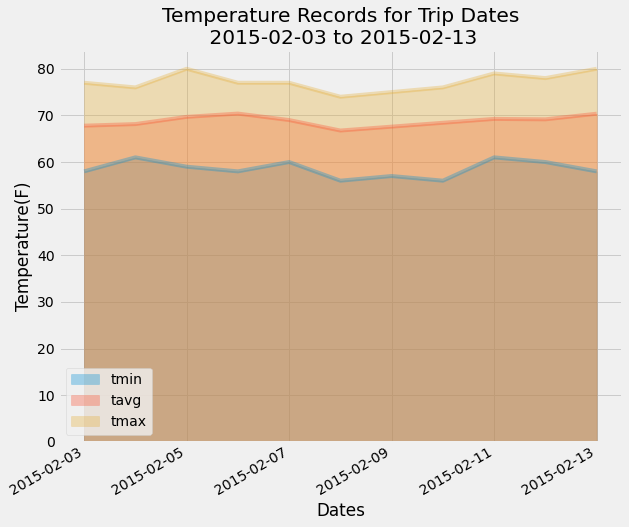

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(9, 8))
plt.title(f"Temperature Records for Trip Dates\n {start_date} to {end_date}")
plt.xlabel("Dates")
plt.ylabel("Temperature(F)")
plt.legend(loc="lower left")
plt.savefig("Images/daily_rainfall_average.png")
plt.show()